This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [1]:
# Ajout DC
# La ligne suivante est inutile dans Google Colab
# !pip install keras keras-hub --upgrade -q

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Timeseries forecasting

### Different kinds of timeseries tasks

### A temperature forecasting example

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-08 14:03:07--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.54.192, 16.182.109.192, 16.182.41.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.54.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  50.9MB/s    in 0.3s    

2025-11-08 14:03:07 (50.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [5]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

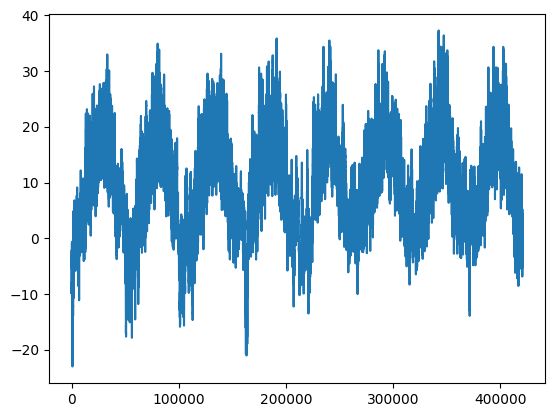

In [7]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

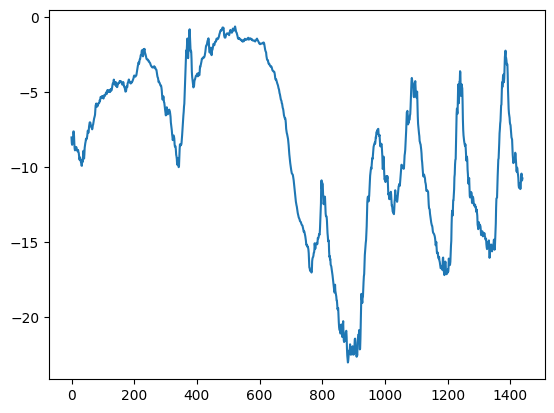

In [8]:
plt.plot(range(1440), temperature[:1440])

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


#### Preparing the data

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#### A commonsense, non-machine-learning baseline

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#### Let's try a basic machine learning model

In [15]:
import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 18.0157 - mae: 3.1781 - val_loss: 10.1943 - val_mae: 2.5125
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7.9950 - mae: 2.2243 - val_loss: 10.2456 - val_mae: 2.5261
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 7.1861 - mae: 2.1090 - val_loss: 10.2269 - val_mae: 2.5182
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.7920 - mae: 2.0497 - val_loss: 10.6422 - val_mae: 2.5661
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 6.4439 - mae: 1.9954 - val_loss: 11.1861 - val_mae: 2.6344
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.3256 - mae: 1.9764 - val_loss: 10.9078 - val_mae: 2.5914
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.1413 - mae: 1.9482 - val_loss: 11.1064 - val_mae: 2.6113
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 5.9883 - mae: 1.9240 - val_loss: 11.1060 - val_mae: 2.6103
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 

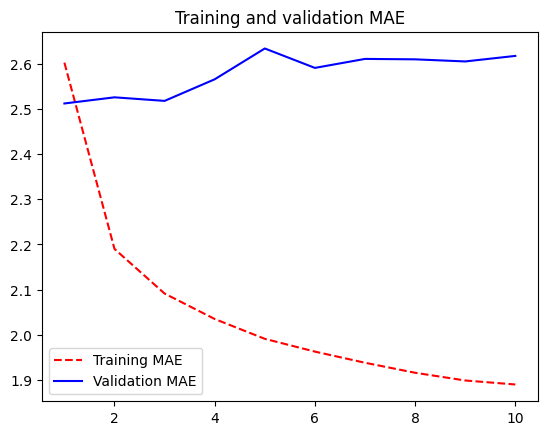

In [16]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#### Let's try a 1D convolutional model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 40.9566 - mae: 4.7226 - val_loss: 14.7429 - val_mae: 3.0190
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 13.8969 - mae: 2.9600 - val_loss: 13.3168 - val_mae: 2.8799
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 12.3332 - mae: 2.7864 - val_loss: 13.3922 - val_mae: 2.8910
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 11.4902 - mae: 2.6886 - val_loss: 12.9627 - val_mae: 2.8428
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 10.8992 - mae: 2.6207 - val_loss: 13.3197 - val_mae: 2.8814
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 10.4438 - mae: 2.5668 - val_loss: 13.1367 - val_mae: 2.8671
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 10.1312 - mae: 2.5292 - val_loss: 13.4535 - val_mae: 2.9031
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.8862 - mae: 2.4991 - val_loss: 13.6195 - val_mae: 2.9177
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━

### Recurrent neural networks

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 75.6061 - mae: 6.6635 - val_loss: 17.3926 - val_mae: 3.1032
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 16.3102 - mae: 3.0550 - val_loss: 11.5404 - val_mae: 2.6011
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 11.7789 - mae: 2.6548 - val_loss: 10.2739 - val_mae: 2.4829
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.4227 - mae: 2.5103 - val_loss: 9.9660 - val_mae: 2.4501
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 9.6298 - mae: 2.4158 - val_loss: 9.6776 - val_mae: 2.4235
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.0652 - mae: 2.3458 - val_loss: 9.5077 - val_mae: 2.4039
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 8.6442 - mae: 2.2922 - val_loss: 9.6865 - val_mae: 2.4305
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 8.3975 - mae: 2.2604 - val_loss: 9.7340 - val_mae: 2.4448
Epoch 9/10
819/819 ━━━━━━━━━━━━━━

#### Understanding recurrent neural networks

In [19]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

#### A recurrent layer in Keras

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [23]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

#### Getting the most out of recurrent neural networks

#### Using recurrent dropout to fight overfitting

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_lstm_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - loss: 58.4772 - mae: 5.7085 - val_loss: 11.5616 - val_mae: 2.6118
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 17.1055 - mae: 3.2084 - val_loss: 9.7062 - val_mae: 2.4153
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 15.5290 - mae: 3.0607 - val_loss: 9.3411 - val_mae: 2.3798
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 14.8095 - mae: 2.9880 - val_loss: 9.3005 - val_mae: 2.3702
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 14.3194 - mae: 2.9402 - val_loss: 9.1628 - val_mae: 2.3501
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 13.9994 - mae: 2.9077 - val_loss: 8.9658 - val_mae: 2.3245
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 13.4085 - mae: 2.8500 - val_loss: 8.8617 - val_mae: 2.3091
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 13.1554 - mae: 2.8171 - val_loss: 8.9184 - val_mae: 2.3174
Epoch 9/50
819/819 ━━━━━━━━━━━━

#### Stacking recurrent layers

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_stacked_gru_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 57ms/step - loss: 52.4724 - mae: 5.4149 - val_loss: 10.7662 - val_mae: 2.4876
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - loss: 15.6732 - mae: 3.0508 - val_loss: 9.2595 - val_mae: 2.3439
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 14.2704 - mae: 2.9210 - val_loss: 8.8700 - val_mae: 2.3035
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 13.6979 - mae: 2.8606 - val_loss: 8.5902 - val_mae: 2.2690
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 13.1863 - mae: 2.8047 - val_loss: 8.5241 - val_mae: 2.2662
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 12.7986 - mae: 2.7636 - val_loss: 8.6848 - val_mae: 2.2998
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 12.4185 - mae: 2.7304 - val_loss: 8.4799 - val_mae: 2.2626
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - loss: 11.9509 - mae: 2.6823 - val_loss: 8.5716 - val_mae: 2.2739
Epoch 9/50
819/819 ━━━━━━━━━━━━

#### Using bidirectional RNNs

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 61.7284 - mae: 5.8730 - val_loss: 12.8140 - val_mae: 2.7506
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 12.7414 - mae: 2.7895 - val_loss: 10.7948 - val_mae: 2.5377
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 10.7350 - mae: 2.5662 - val_loss: 10.7289 - val_mae: 2.5311
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 10.1444 - mae: 2.4940 - val_loss: 9.9979 - val_mae: 2.4513
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 9.4577 - mae: 2.4014 - val_loss: 10.0910 - val_mae: 2.4655
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 8.9993 - mae: 2.3337 - val_loss: 9.8486 - val_mae: 2.4271
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 8.7280 - mae: 2.2996 - val_loss: 9.4452 - val_mae: 2.3919
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 8.6726 - mae: 2.2888 - val_loss: 9.5942 - val_mae: 2.4084
Epoch 9/10
819/819 ━━━━━━━━━━━━━

### Going even further